# 2D Occlusion

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/26<br>
**Last modified:** 2021/03/07<br>
**Description:** How to obtain a class activation heatmap for an image classification model.

Adapted from Deep Learning with Python (2017).
## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


## Configurable parameters

You can change these to another model.

To get the values for `last_conv_layer_name` use `model.summary()`
to see the names of all layers in the model.

In [2]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = keras.utils.get_file(
    "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
)

# display(Image(img_path))


## The Occlusion algorithm

In [3]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [4]:
from scipy import stats
from tqdm import tqdm

def iter_occlusion(volume, size=4, stride = None):
  # volume: np array in shape 128, 128, 64, 1

  occlusion_center = np.full((size, size, 3), [0], np.float32)

  for y in range(0, volume.shape[0]-size+1, stride):
    for x in range(0, volume.shape[1]-size+1, stride):
      tmp = volume.copy()

      tmp[y:y + size, x:x + size, :] = occlusion_center

      yield x, y, tmp
  
def rgb_image_occlusion(volume, correct_class, occlusion_size, occlusion_stride = None):

  print('occluding...')

  if occlusion_stride is None:
    stride = occlusion_size
  elif occlusion_stride > occlusion_size:
    raise ValueError('stride must be smaller or equal size')
  
  if occlusion_stride == occlusion_size:
    if (not (volume.shape[0] / occlusion_size).is_integer() or
        not (volume.shape[1] / occlusion_size).is_integer()):
      
      raise ValueError('size does not work with this volume')
  elif occlusion_stride != occlusion_size:
    if (((volume.shape[0]-occlusion_size) % occlusion_stride) != 0 or 
        ((volume.shape[1]-occlusion_size) % occlusion_stride) != 0):
      
      raise ValueError('shape and size do not match')

  num_occlusion =  int(np.prod(((np.array(volume.shape[0:2]) - occlusion_size) / occlusion_stride) + 1))
  
  # heatmap_n = np.empty((num_occlusion, volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
  # heatmap_n[:] = np.nan
  # class_pixels_n = np.empty((num_occlusion, volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
  # class_pixels_n[:] = np.nan

  heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1]), np.float32)
  heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1]), np.float32)

  from collections import defaultdict
  counters = defaultdict(int)

  for n, (x, y, vol_float) in tqdm(enumerate(iter_occlusion(volume, size = occlusion_size, stride = occlusion_stride))):
      X = vol_float.reshape(1, 299, 299, 3)
      out = model.predict(X)
      # print(out)
      # print('#{}: {} @ {} (correct class: {})'.format(n, np.argmax(out), np.amax(out), out[0][correct_class]))
      # print('x {} - {} | y {} - {}'.format(x, x + occlusion_size, y, y + occlusion_size))
      # plt.imshow((np.squeeze(X)+1)/2, vmin = 0, vmax = 1)
      # plt.show()

      # print(n)

      # heatmap_n[n, z:z + occlusion_size, y:y + occlusion_size, x:x + occlusion_size] = out[0,0] #[correct_class]
      # class_pixels_n[n, z:z + occlusion_size, y:y + occlusion_size, x:x + occlusion_size] = 1 if out[0,0] > 0.5 else 0 #np.argmax(out)

      heatmap_prob_sum[y:y + occlusion_size, x:x + occlusion_size] += out[0,correct_class]
      heatmap_occ_n[y:y + occlusion_size, x:x + occlusion_size] += 1

      counters[np.argmax(out)] += 1

  print("\n")
  print("calculating heatmap...")
  # heatmap = np.mean(np.ma.array(heatmap_n, mask=np.isnan(heatmap_n)), axis = 0)
  # class_pixels = np.reshape(stats.mode(class_pixels_n, axis = 0, nan_policy = "omit")[0], (volume.shape))

  heatmap = heatmap_prob_sum/heatmap_occ_n

  return heatmap#, class_pixels


## Let's test-drive it

In [5]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))

print("array shape: ", img_array.shape)

occ_size = 38
occ_stride = 9
print("number of occlusions: ", int(np.prod(((np.array(img_array.shape[1:3]) - occ_size) / occ_stride) + 1)))
print((np.asarray(img_array[0,:,:,0].shape) - occ_size) % occ_stride)

array shape:  (1, 299, 299, 3)
number of occlusions:  900
[0 0]


In [6]:
# Prepare image

# Make model
model = model_builder(weights="imagenet")

preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=5)[0])

Predicted: [('n02504458', 'African_elephant', 0.8871446), ('n01871265', 'tusker', 0.05058822), ('n02504013', 'Indian_elephant', 0.011148933), ('n02172182', 'dung_beetle', 0.00029058155), ('n02391049', 'zebra', 0.0002699783)]


In [7]:
# 101 tusker
# 385 indian elephant
# 386 african elephant
preds[0, 386]

0.8871446

## Create a superimposed visualization

In [8]:
def generate_superimposed_image(heatmap, modprob):
  f, axs = plt.subplots(1, 3, figsize=(24,8))
  (ax1, ax2, ax3) = axs

  ax1.imshow((img_array[0]+1)/2, vmin = 0, vmax = 1)
  ax2.imshow((img_array[0]+1)/2, vmin = 0, vmax = 1)
  ax2.imshow(heatmap, cmap='jet_r', vmin = np.min(heatmap), vmax = np.max(heatmap), alpha=0.4)
  im = ax3.imshow(heatmap, cmap='jet_r', vmin = np.min(heatmap), vmax = np.max(heatmap), alpha=0.4)
  cb = f.colorbar(im, ax=axs.ravel().tolist())
  cb.ax.axhline(y=modprob, linewidth = 3, c='black')

occluding...


900it [00:55, 16.23it/s]




calculating heatmap...
0.8871446


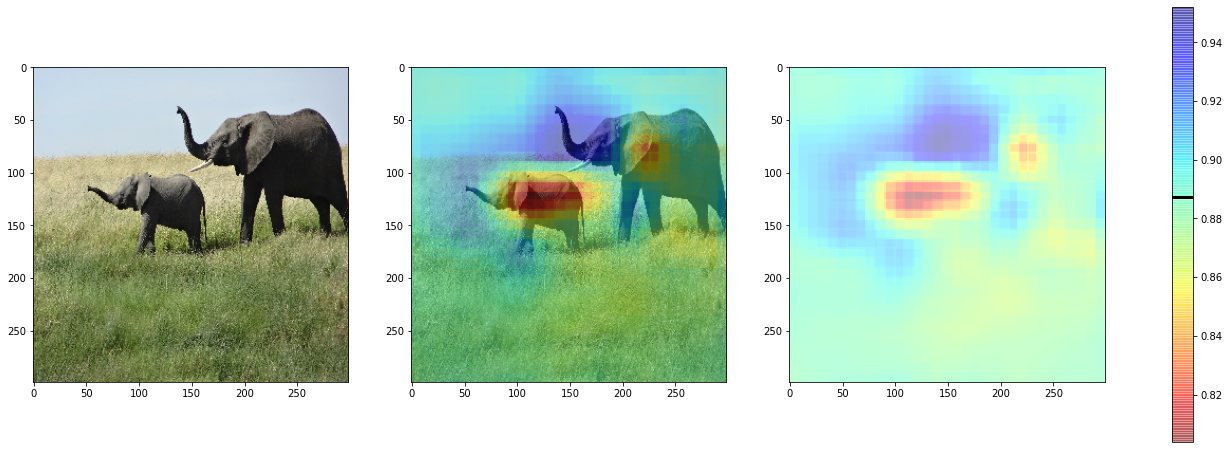

In [9]:
(heatmap0) =  rgb_image_occlusion(img_array[0, :, :, :], correct_class = 386, occlusion_size = occ_size, occlusion_stride = occ_stride)
probab = preds[0, 386]
print(probab)
generate_superimposed_image(heatmap0, probab)

Let's try it on a tusker (longer tusks)

occluding...


900it [01:02, 14.33it/s]




calculating heatmap...
0.05058822


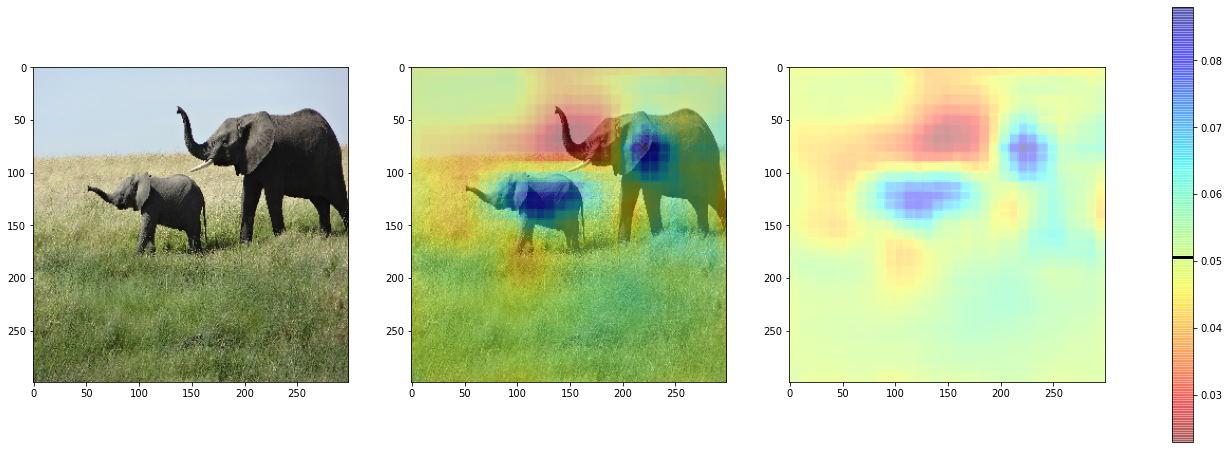

In [11]:
(heatmap1) =  rgb_image_occlusion(img_array[0, :, :, :], correct_class = 101, occlusion_size = occ_size, occlusion_stride = occ_stride)
probab = preds[0, 101]
print(probab)
generate_superimposed_image(heatmap1, probab)

Let's try it on an indian elephant (smaller ears)

occluding...


900it [00:56, 15.84it/s]




calculating heatmap...
0.011148933


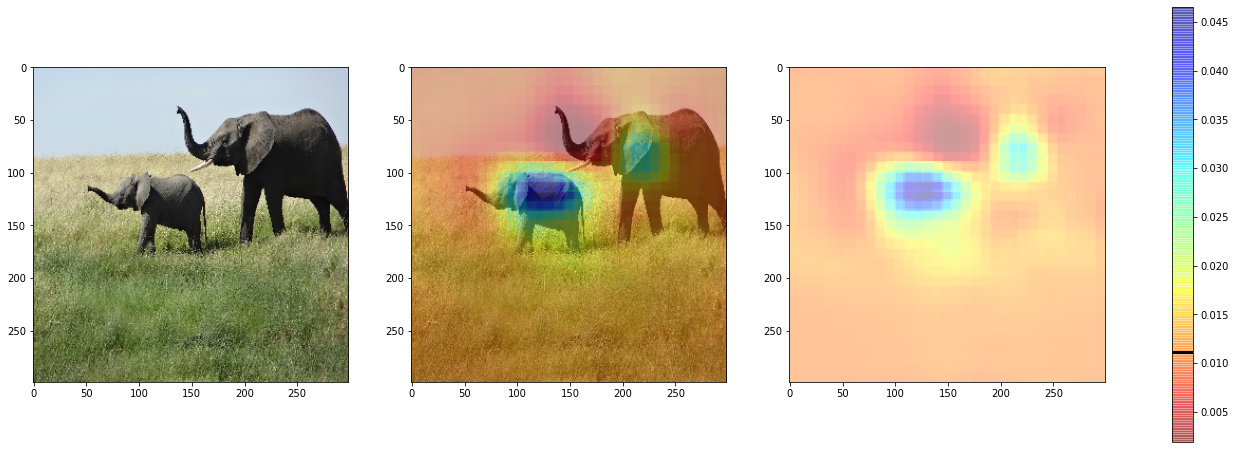

In [10]:
(heatmap2) =  rgb_image_occlusion(img_array[0, :, :, :], correct_class = 385, occlusion_size = occ_size, occlusion_stride = occ_stride)
probab = preds[0, 385]
print(probab)
generate_superimposed_image(heatmap2, probab)

Let's also try it on a completly wrong class (Persian cat)

occluding...


900it [00:56, 15.94it/s]




calculating heatmap...
4.6604422e-05


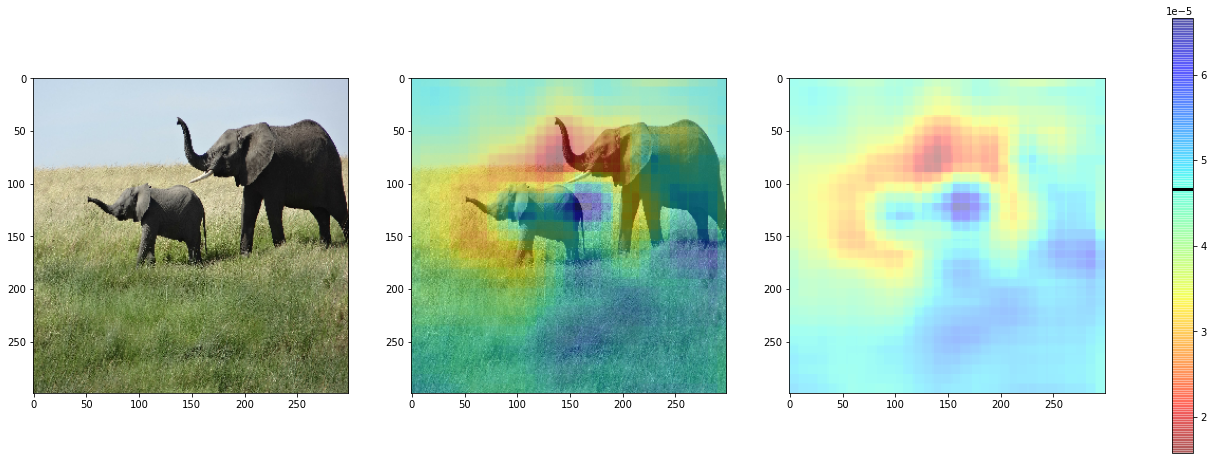

In [12]:
(heatmap3) =  rgb_image_occlusion(img_array[0, :, :, :], correct_class = 283, occlusion_size = occ_size, occlusion_stride = occ_stride)
probab = preds[0, 283]
print(probab)
generate_superimposed_image(heatmap3, probab)